In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax as tx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

from jax.example_libraries import optimizers
from jax.example_libraries.optimizers import adamax as optimizer
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update('jax_disable_jit', True)
# import os
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.50'
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

In [2]:
SCALE = 1e-2
INIT_KEYS = jax.random.split(jax.random.PRNGKey(1), 8)
KEY = jax.random.PRNGKey(42)
TRAIN_NEW = True

BETA = 0.8
MAX_AGE = 2.
MIN_DP = 0.2
INTEREST = 0.5

R = (1 + INTEREST)
B = BETA
BR = B * R
OBJECTIVE_FN = lambda x, t: jax.lax.select((jnp.where(t == 1, size=1)[0] == 2)[0], 
                                           jnp.array([jnp.log(x), 
                                                      x, 
                                                      0., 
                                                      1.]), 
                                           jax.lax.select((jnp.where(t == 1, size=1)[0] == 1)[0], 
                                                          jnp.array([jnp.log((1 / (1 + B)) * x) + BETA * jnp.log(R * (1 - (1 / (1 + B))) * x), 
                                                                     (1 / (1 + B)) * x, 
                                                                     R * (1 - (1 / (1 + B))) * x, 
                                                                     1.]), 
                                                          jax.lax.select((jnp.where(t == 1, size=1)[0] == 0)[0],
                                                              jnp.array([jnp.log((1 / (1 + B + B**2)) * x) +\
                                                                         BETA * jnp.log((1 / (1 + B)) * R * (1 - (1 / (1 + B + B**2))) * x) +\
                                                                         BETA**2 * jnp.log(R * (B / (1 + B)) * R * (1 - (1 / (1 + B + B**2))) * x),
                                                                         ((1) / (1 + B + B**2)) * x,
                                                                         R * (1 - ((1) / (1 + B + B**2))) * x,
                                                                         1.]),
                                                              jnp.array([0., 0., 0., 1.]))))


HIDDEN_STATE_SIZE = 8
GRID_SIZE = 100
X = jnp.linspace(1e-5, 1, GRID_SIZE)
STATE_SPACE = jnp.concatenate((
    jnp.concatenate((X.reshape(-1, 1), jnp.ones((GRID_SIZE, 1))), axis=1),
    jnp.concatenate((X.reshape(-1, 1), jnp.zeros((GRID_SIZE, 1))), axis=1)),
axis=0)

In [3]:
# class RNN(nn.Module):
#     state_size: int
    
#     @nn.compact
#     def __call__(self, x, inputs):
#         o = inputs[-1]
#         t = inputs[1:5]
        
#         # Input layer
#         h0 = nn.Dense(x[0].shape[0])(inputs[1:])
        
#         # Yellow Block
#         h1, y1 = nn.GRUCell()(x[0], h0)
#         h2, y2 = nn.GRUCell()(x[1], h1)
#         hn, yn = nn.GRUCell()(x[2], h2)
#         ys = jnp.concatenate((y1[jnp.newaxis], y2[jnp.newaxis], yn[jnp.newaxis]), axis=0)
        
#         # Blue Block
#         c1 = jnp.sum(jax.nn.softmax(nn.Dense(3)(ys)).reshape(-1, 1) * ys.reshape(-1), axis=0)
#         c2 = jnp.sum(jax.nn.softmax(nn.Dense(3)(ys)).reshape(-1, 1) * ys.reshape(-1), axis=0)
#         cn = jnp.sum(jax.nn.softmax(nn.Dense(3)(ys)).reshape(-1, 1) * ys.reshape(-1), axis=0)
        
#         d1, u1 = nn.GRUCell()(c1, hn)
#         d2, u2 = nn.GRUCell()(jnp.concatenate((c2, u1)), d1)
#         dn, un = nn.GRUCell()(jnp.concatenate((cn, u2)), d2)

#         new_states = jnp.array([h1, h2, hn])
        
#         cu = inputs[0] * sigmoid_output(nn.Dense(1)(un))
#         c = jax.lax.select((jnp.where(t == 1, size=1)[0][0] >= MAX_AGE), inputs[0][jnp.newaxis], cu)
        
#         o1 = jnp.minimum(jnp.int32(inputs[0] - c >= MIN_DP) + o, 1.)
        
#         vu = linear_output(nn.Dense(1)(jnp.concatenate((un, o1))))
#         v = jax.lax.select((jnp.where(t == 1, size=1)[0][0] > MAX_AGE), jnp.zeros(1), vu)
   
#         predictions = tuple((v, c))
#         return new_states, predictions

In [10]:
@jax.jit
def sigmoid_output(x):
    return jax.nn.sigmoid(x / 1e1)


@jax.jit
def custom_value_fn(x):
    x = (x / 1e-1) + 0.5 
    out = jax.lax.select((x > 1), 
                         jnp.log(jnp.abs(x) + 1e-5) + 1,
                         jax.lax.select((x < -1),
                                        -1 * (1/2)*jnp.power(x, 2) - (1/2),
                                        x))
    return out


@jax.jit
def linear_output(x):
    return 10 * x


@jax.jit
def encoder_gru(h, x):
    return nn.GRUCell()(h, x)


@jax.jit
def attention_weights(ys):
    return jnp.sum(jax.nn.softmax(nn.Dense(GRID_SIZE)(ys)).reshape(-1, 1) * ys, axis=0)


@jax.jit
def decoder_gru(ys, d):
    c = attention_weights(ys)
    d, u = nn.GRUCell()(d, c)
    return jnp.concatenate((d, u)), u


class RNN(nn.Module):
    grid_size: int
    hidden_state_size: int
    
    @nn.compact
    def __call__(self, state, inputs):
        # Components of the state are savings and owner status (0/1)
        X = state[:, 0]
        o = state[:, 1]
        t = jnp.where(inputs == 1, size=1)[0][0]
        
        # Input layer
        h0 = nn.Dense(self.hidden_state_size)(inputs)
        
        # Encoder Block
        hn, ys = nn.scan(nn.GRUCell)(h0, state)
        ys = ys.reshape(self.grid_size, self.hidden_state_size) 
        
        # Decoder Block
        decoder_fn = jax.tree_util.Partial(decoder_gru, ys)
        dn, us = nn.scan(decoder_fn, hn, length=self.grid_size)
        us = us.reshape(-1)
        
        # Output layers
        cu = X * sigmoid_output(un) # (n,) vector
        c = jax.lax.select((t >= MAX_AGE), state, cu)
        
        o1 = jnp.minimum(jnp.int32(X - c >= MIN_DP) + o, 1.)
        
        vu = linear_output(nn.Dense(self.grid_size)(jnp.concatenate((un, o1))))
        v = jax.lax.select((t > MAX_AGE), jnp.zeros(self.grid_size), vu)
   
        predictions = jnp.concatenate((v.reshape(-1, 1), c.reshape(-1, 1)))
        return state, predictions

    def init_state(self):
        return STATE_SPACE

    
@jax.jit
def increment_t(t):
    i = jnp.where(t == 1, size=1)[0]
    return t.at[i].set(0).at[i+1].set(1)


@jax.tree_util.Partial(jax.jit, static_argnums=(1,))
def neural_network(params, model, model_state, inputs):
    model_state, out = model.apply(params, model_state, inputs)
    mat = jnp.concatenate((model_state, out), axis=1) # For a given t, we have a tensor of (X, o, v, c)
    # So we just need to add o1 and x1 columns to this tensor
    o1 = jnp.minimum(jnp.int32(mat[:, 0] - mat[:, 3] >= MIN_DP) + mat[:, 1], 1.)
    x1 = (1 + o1 * INTEREST) * (mat[:, 0] - mat[:, 3])
    predictions = jnp.concatenate((mat[:, 2:], x1.reshape(-1, 1), o1.reshape(-1, 1)), axis=1)
    return model_state, predictions


@jax.tree_util.Partial(jax.jit, static_argnums=(1,))
def loss(params, model, model_state, t0):
    t1 = increment_t(t0)
    _, preds0 = neural_network(params, model, model_state, t0)
    predicted_state = preds0[:, 2:]
    _, preds1 = neural_network(params, model, predicted_state, t1)
    
    v0 = preds0[:, 0]
    c0 = preds0[:, 1]
    o0 = model_state[:, 1]
    v1 = preds1[:, 0]
    c1 = preds1[:, 1]
    
    vf = lambda model_state, t: neural_network(params, model, model_state, t)[1][:, 0]
    cf = lambda model_state, t: neural_network(params, model, model_state, t)[1][:, 1]
    
    c0x = jax.grad(cf)(model_state, t0)[0] # Should be (GRID_SIZE,), just like v and c
    v0x = jax.grad(vf)(model_state, t0)[0]
    v1x = jax.grad(vf)(preds0[:, 2:], t1)[0]
    
    live_next = (jnp.where(t == 1, size=1)[0][0] < MAX_AGE)
    loss_euler = jax.lax.select(live_next, o0 * (c1 - BR * c0), 0.)
    loss_bellman = ((jnp.log(c0) + BETA * v1) - v0)
    loss_foc = jax.lax.select(live_next, BR * v1x  * c0 - 1, 0.)
    loss_envelope = (c0x - c0 * v0x)
    
    return model_state, jnp.concatenate((loss_euler.reshape(-1, 1), loss_bellman.reshape(-1, 1), loss_foc.reshape(-1, 1), loss_envelope.reshape(-1, 1)), axis=1)


@jax.tree_util.Partial(jax.jit, static_argnums=(1,))
def batch_loss(params, model, model_state, batch, W):
    model_state, losses = jax.lax.scan(lambda state, x: loss(params, model, state, x), model_state, batch)
    mean_losses = jnp.squeeze(jnp.mean(losses**2, axis=0))
    return jnp.sum(W * mean_losses), tuple((model_state, mean_losses[0], mean_losses[1], mean_losses[2], mean_losses[3]))

In [20]:
@jax.tree_util.Partial(jax.jit, static_argnums=(1, 4))
def step(params, model, model_state, opt_state, optimizer, batch, W):
    (loss, (model_state, loss_euler, loss_bellman, loss_foc, loss_envelope)), grad = jax.value_and_grad(batch_loss, has_aux=True)(params, model, model_state, batch, W)
    updates, opt_state = optimizer.update(grad, opt_state, params)
    params = tx.apply_updates(params, updates)
    loss_components = tuple((loss_euler, loss_bellman, loss_foc, loss_envelope))
    return params, model_state, opt_state, loss, loss_components


def training_loop(grid, model, params, model_state, opt_state, optimizer, W=jnp.ones(4), max_iter=1000):
    j = 0
    while j < max_iter:
        params, model_state, opt_state, loss, loss_components = step(params, model, model_state, opt_state, optimizer, grid, W)
        
        if j == 0:
            start_time = time.time()
        
        if j % 1 == 0:
            print(f'Iteration: {j}\tCurrent Loss: {loss:.2f}\tAverage samples/s: {((grid.shape[0] * j) / (time.time() - start_time)):.2f}\n'
                  f'Loss Euler: {loss_components[0]:.2e}\tLoss Bellman: {loss_components[1]:.2e}\tLoss FoC: {loss_components[2]:.2e}\tLoss Envelope: {loss_components[3]:.2e}')
        j += 1
        
    return params, opt_state, model_state

In [22]:
model = RNN(GRID_SIZE, HIDDEN_STATE_SIZE)
optimizer = tx.adam(learning_rate=1e-2)

init_model_state = model.init_state()
init_params = model.init(KEY, init_model_state, jnp.array([1, 0, 0, 0]))
init_opt_state = optimizer.init(init_params)

if TRAIN_NEW:
    model_state = init_model_state
    params = init_params
    opt_state = init_opt_state
else:
    params, opt_state, model_state, model = pickle.load(open('owner_rnn_kink.pkl', 'rb'))
    
W = jnp.array([1e1, 1., 0., 0.])
GRID = jnp.concatenate((jnp.eye(3), jnp.zeros(3).reshape(-1, 1)), axis=1) # 3 different ages

params, opt_state, model_state = training_loop(GRID, model, params, model_state, opt_state, optimizer, W=W, max_iter=5)

TypeError: cannot unpack non-iterable ScanGRUCell object

In [6]:
pickle.dump(tuple((params, opt_state, model_state, model)), open('owner_rnn_kink.pkl', 'wb'))

In [7]:
OWNER_PARAMS, OWNER_OPT_STATE, OWNER_MODEL_STATE, OWNER_MODEL = pickle.load(open('owner_rnn_kink.pkl', 'rb'))

@jax.tree_util.Partial(jax.jit, static_argnums=(1,))
def neural_network(params, model, model_state, inputs):
    o = inputs[-1]
    owner_model_state, (ov0, oc0) = OWNER_MODEL.apply(OWNER_PARAMS, OWNER_MODEL_STATE, inputs)
    renter_model_state, (rv0, rc0) = model.apply(params, model_state, inputs)
    model_state = jax.lax.select((o == 1.), owner_model_state, renter_model_state)
    v0 = jax.lax.select((o == 1.), ov0, rv0)
    c0 = jax.lax.select((o == 1.), oc0, rc0)
    o1 = jnp.int32(jnp.logical_or((inputs[-1] == 1.), (inputs[0] - c0 >= MIN_DP)))
    x1 = (1 + o1 * INTEREST) * (inputs[0] - c0)
    return model_state, tuple((v0, c0, x1, o1))

In [8]:
model = RNN(STATE_SIZE)
model_state = model.init_state()
params = model.init(KEY, init_model_state, all_grid[0])
opt_state = optimizer.init(init_params)

W = jnp.diag(jnp.array([1., 1., 1., 1.]))
GRID = all_grid

params, opt_state, model_state = training_loop(GRID, model, params, model_state, opt_state, optimizer, W=W, max_iter=5000)

Iteration: 0	Current Loss: 4627.77	Fair Loss: 196060.02	Average samples/s: 0.00
Loss Euler: 3.94e+00	Loss Bellman: 3.81e+03	Loss FoC: 4.73e+02	Loss Envelope: 3.44e+02
Iteration: 100	Current Loss: 505.68	Fair Loss: 3588.75	Average samples/s: 242.44
Loss Euler: 4.63e+00	Loss Bellman: 3.58e+02	Loss FoC: 7.51e+01	Loss Envelope: 6.78e+01
Iteration: 200	Current Loss: 320.89	Fair Loss: 2653.38	Average samples/s: 250.31
Loss Euler: 3.74e+00	Loss Bellman: 2.48e+02	Loss FoC: 3.92e+01	Loss Envelope: 2.96e+01
Iteration: 300	Current Loss: 143.48	Fair Loss: 2210.57	Average samples/s: 252.90
Loss Euler: 3.74e+00	Loss Bellman: 1.08e+02	Loss FoC: 1.77e+01	Loss Envelope: 1.37e+01
Iteration: 400	Current Loss: 99.86	Fair Loss: 2175.03	Average samples/s: 254.31
Loss Euler: 3.47e+00	Loss Bellman: 7.37e+01	Loss FoC: 1.31e+01	Loss Envelope: 9.56e+00
Iteration: 500	Current Loss: 107.10	Fair Loss: 1908.80	Average samples/s: 255.24
Loss Euler: 3.06e+00	Loss Bellman: 8.41e+01	Loss FoC: 1.13e+01	Loss Envelope: 8.6

Iteration: 4900	Current Loss: 82.39	Fair Loss: 2081.66	Average samples/s: 258.37
Loss Euler: 1.15e+00	Loss Bellman: 7.00e+01	Loss FoC: 7.34e+00	Loss Envelope: 3.89e+00


In [9]:
pickle.dump(tuple((params, opt_state, model_state, model)), open('renter_rnn_kink.pkl', 'wb'))

In [10]:
RENTER_PARAMS, RENTER_OPT_STATE, RENTER_MODEL_STATE, RENTER_MODEL = pickle.load(open('renter_rnn_kink.pkl', 'rb'))

In [11]:
X = jnp.linspace(1e-5, 1, 1000)

inputs00 = jnp.concatenate((X.reshape(-1, 1), jnp.repeat(jnp.array([[1., 0., 0., 0.]]), X.shape[0], axis=0), jnp.zeros(X.shape[0]).reshape(-1, 1)), axis=1)
inputs01 = jnp.concatenate((X.reshape(-1, 1), jnp.repeat(jnp.array([[1., 0., 0., 0.]]), X.shape[0], axis=0), jnp.ones(X.shape[0]).reshape(-1, 1)), axis=1)
inputs10 = jnp.concatenate((X.reshape(-1, 1), jnp.repeat(jnp.array([[0., 1., 0., 0.]]), X.shape[0], axis=0), jnp.zeros(X.shape[0]).reshape(-1, 1)), axis=1)
inputs11 = jnp.concatenate((X.reshape(-1, 1), jnp.repeat(jnp.array([[0., 1., 0., 0.]]), X.shape[0], axis=0), jnp.ones(X.shape[0]).reshape(-1, 1)), axis=1)
inputs20 = jnp.concatenate((X.reshape(-1, 1), jnp.repeat(jnp.array([[0., 0., 1., 0.]]), X.shape[0], axis=0), jnp.zeros(X.shape[0]).reshape(-1, 1)), axis=1)
inputs21 = jnp.concatenate((X.reshape(-1, 1), jnp.repeat(jnp.array([[0., 0., 1., 0.]]), X.shape[0], axis=0), jnp.ones(X.shape[0]).reshape(-1, 1)), axis=1)

_, (v00, c00) = jax.vmap(lambda inputs: RENTER_MODEL.apply(RENTER_PARAMS, RENTER_MODEL_STATE, inputs))(inputs00)
_, (v01, c01) = jax.vmap(lambda inputs: OWNER_MODEL.apply(OWNER_PARAMS, OWNER_MODEL_STATE, inputs))(inputs01)
_, (v10, c10) = jax.vmap(lambda inputs: RENTER_MODEL.apply(RENTER_PARAMS, RENTER_MODEL_STATE, inputs))(inputs10)
_, (v11, c11) = jax.vmap(lambda inputs: OWNER_MODEL.apply(OWNER_PARAMS, OWNER_MODEL_STATE, inputs))(inputs11)
_, (v20, c20) = jax.vmap(lambda inputs: RENTER_MODEL.apply(RENTER_PARAMS, RENTER_MODEL_STATE, inputs))(inputs20)
_, (v21, c21) = jax.vmap(lambda inputs: OWNER_MODEL.apply(OWNER_PARAMS, OWNER_MODEL_STATE, inputs))(inputs21)

v00 = jnp.squeeze(v00)
v01 = jnp.squeeze(v01)
v10 = jnp.squeeze(v10)
v11 = jnp.squeeze(v11)
v20 = jnp.squeeze(v20)
v21 = jnp.squeeze(v21)
c00 = jnp.squeeze(c00)
c01 = jnp.squeeze(c01)
c10 = jnp.squeeze(c10)
c11 = jnp.squeeze(c11)
c20 = jnp.squeeze(c20)
c21 = jnp.squeeze(c21)

o10 = jax.vmap(lambda x, c: jnp.int32((x - c >= MIN_DP)))(X, c00)
o20 = jax.vmap(lambda x, c: jnp.int32((x - c >= MIN_DP)))(X, c10)
o30 = jax.vmap(lambda x, c: jnp.int32((x - c >= MIN_DP)))(X, c20)

x00 = (1 + o10 * INTEREST) * (X - c00)
x01 = (1 + INTEREST) * (X - c01)
x10 = (1 + o20 * INTEREST) * (X - c10)
x11 = (1 + INTEREST) * (X - c11)
x20 = (1 + o30 * INTEREST) * (X - c20)
x21 = (1 + INTEREST) * (X - c21)

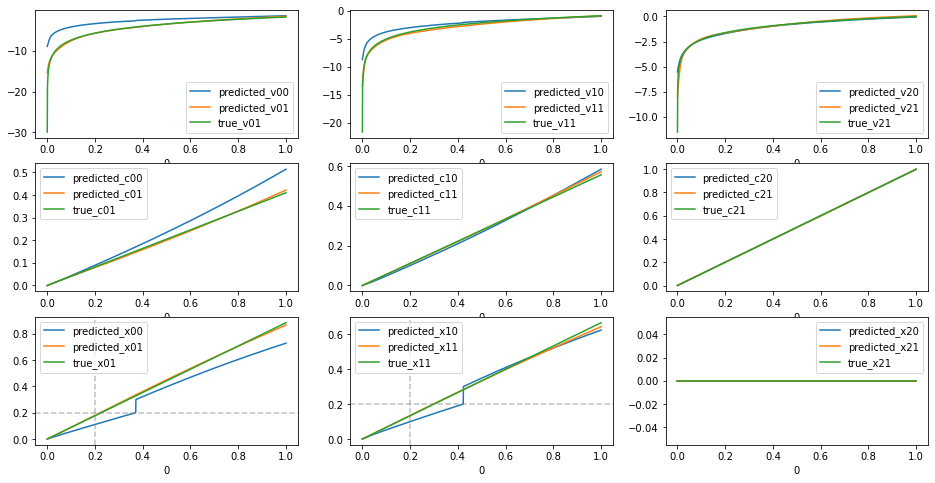

In [12]:
true01 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([1., 0., 0., 0.]))
true11 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0., 1., 0., 0.]))
true21 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0., 0., 1., 0.]))
                                                                 
df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1),
                                   v00.reshape(-1, 1), c00.reshape(-1, 1), x00.reshape(-1, 1),
                                   v01.reshape(-1, 1), c01.reshape(-1, 1), x01.reshape(-1, 1),
                                   v10.reshape(-1, 1), c10.reshape(-1, 1), x10.reshape(-1, 1),
                                   v11.reshape(-1, 1), c11.reshape(-1, 1), x11.reshape(-1, 1),
                                   v20.reshape(-1, 1), c20.reshape(-1, 1), x20.reshape(-1, 1), 
                                   v21.reshape(-1, 1), c21.reshape(-1, 1), x21.reshape(-1, 1),
                                   true01, true11, true21), 
                                  axis=1)).astype(np.float32).set_index(0)
df.columns = [
    'predicted_v00', 'predicted_c00', 'predicted_x00',
    'predicted_v01', 'predicted_c01', 'predicted_x01',
    'predicted_v10', 'predicted_c10', 'predicted_x10',
    'predicted_v11', 'predicted_c11', 'predicted_x11',
    'predicted_v20', 'predicted_c20', 'predicted_x20',
    'predicted_v21', 'predicted_c21', 'predicted_x21',
    'true_v01', 'true_c01', 'true_x01', 'true_011',
    'true_v11', 'true_c11', 'true_x11', 'true_021',
    'true_v21', 'true_c21', 'true_x21', 'true_031']

fig, axes = plt.subplots(3, 3, figsize=(16, 8))
df.plot(y=['predicted_v00'], ax=axes.flatten()[0])
df.plot(y=['predicted_v10'], ax=axes.flatten()[1])
df.plot(y=['predicted_v20'], ax=axes.flatten()[2])
df.plot(y=['predicted_v01'], ax=axes.flatten()[0])
df.plot(y=['predicted_v11'], ax=axes.flatten()[1])
df.plot(y=['predicted_v21'], ax=axes.flatten()[2])
df.plot(y=['predicted_c00'], ax=axes.flatten()[3])
df.plot(y=['predicted_c10'], ax=axes.flatten()[4])
df.plot(y=['predicted_c20'], ax=axes.flatten()[5])
df.plot(y=['predicted_c01'], ax=axes.flatten()[3])
df.plot(y=['predicted_c11'], ax=axes.flatten()[4])
df.plot(y=['predicted_c21'], ax=axes.flatten()[5])
df.plot(y=['predicted_x00'], ax=axes.flatten()[6])
df.plot(y=['predicted_x10'], ax=axes.flatten()[7])
df.plot(y=['predicted_x20'], ax=axes.flatten()[8])
df.plot(y=['predicted_x01'], ax=axes.flatten()[6])
df.plot(y=['predicted_x11'], ax=axes.flatten()[7])
df.plot(y=['predicted_x21'], ax=axes.flatten()[8])                                     
df.plot(y=['true_v01'], ax=axes.flatten()[0])
df.plot(y=['true_v11'], ax=axes.flatten()[1])
df.plot(y=['true_v21'], ax=axes.flatten()[2])
df.plot(y=['true_c01'], ax=axes.flatten()[3])
df.plot(y=['true_c11'], ax=axes.flatten()[4])
df.plot(y=['true_c21'], ax=axes.flatten()[5])
df.plot(y=['true_x01'], ax=axes.flatten()[6])
df.plot(y=['true_x11'], ax=axes.flatten()[7])
df.plot(y=['true_x21'], ax=axes.flatten()[8])
                                                   
for ax in axes.flatten()[6:8]:
    ax.axhline(y=MIN_DP, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(x=MIN_DP, color='grey', linestyle='--', alpha=0.5)

In [22]:
HIDDEN_STATE_SIZE = 8
GRID_SIZE = STATE_SPACE.shape[0]


@jax.jit
def attention_weights(ys):
    return jnp.sum(jax.nn.softmax(nn.Dense(1)(ys)).reshape(-1, 1) * ys, axis=0)


@jax.jit
def decoder_gru(ys, d):
    c = attention_weights(ys)
    d, u = nn.GRUCell()(d, c)
    carry = jnp.concatenate((d.reshape(-1), u.reshape(-1)))
    return carry, u


class test_rnn(nn.Module):
    grid_size: int
    hidden_state_size: int
    
    @nn.compact
    def __call__(self, states, inputs):
        # Components of the state are savings and owner status (0/1)
        X = states[:, 0]
        o = states[:, 1]
        t = jnp.where(inputs == 1, size=1)[0][0]
        
        # Input layer
        h0 = nn.Dense(self.hidden_state_size)(inputs)
        hn, ys = nn.GRUCell()(h0, states[0])
        ys = ys.reshape(1, -1)
        
        # Encoder Block
        for state in states[1:]:
            hn, y = nn.GRUCell()(hn, state)
            ys = jnp.concatenate((ys, y.reshape(1, -1)), axis=0)
            
        # Decoder Block
        decoder_fn = jax.tree_util.Partial(decoder_gru, ys)
        dn, us = decoder_fn(hn)
        us = nn.Dense(1)(us).reshape(-1)
        for i in range(self.grid_size - 1):
            dn, u = decoder_fn(dn)
            dn = nn.Dense(8)(dn)
            u = nn.Dense(1)(u)
            us = jnp.concatenate((us, u.reshape(-1)))
        
        # Output layers
        cu = X * sigmoid_output(us) # (n,) vector
        c = jax.lax.select((t >= MAX_AGE), X, cu)
        
        o1 = jnp.minimum(jnp.int32(X - c >= MIN_DP) + o, 1.)
        
        vu = linear_output(nn.Dense(self.grid_size)(jnp.concatenate((us, o1))))
        v = jax.lax.select((t > MAX_AGE), jnp.zeros(self.grid_size), vu)
   
        predictions = jnp.concatenate((v.reshape(-1, 1), c.reshape(-1, 1)))
        return state, predictions
    
    def init_state(self):
        return STATE_SPACE


model = test_rnn(GRID_SIZE, HIDDEN_STATE_SIZE)
optimizer = tx.adam(learning_rate=1e-2)
carry = nn.GRUCell.initialize_carry(KEY, (GRID_SIZE,), HIDDEN_STATE_SIZE)

init_model_state = model.init_state()
init_params = model.init(KEY, STATE_SPACE, jnp.array([[1, 0, 0, 0]]))
init_opt_state = optimizer.init(init_params)

out = model.apply(init_params, STATE_SPACE, jnp.array([[1, 0, 0, 0]]))
print(out[0].shape)
print(out[1].shape)

(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(10,)
(11,)
(12,)
(13,)
(14,)
(15,)
(16,)
(17,)
(18,)
(19,)
(20,)
(21,)
(22,)
(23,)
(24,)
(25,)
(26,)
(27,)
(28,)
(29,)
(30,)
(31,)
(32,)
(33,)
(34,)
(35,)
(36,)
(37,)
(38,)
(39,)
(40,)
(41,)
(42,)
(43,)
(44,)
(45,)
(46,)
(47,)
(48,)
(49,)
(50,)
(51,)
(52,)
(53,)
(54,)
(55,)
(56,)
(57,)
(58,)
(59,)
(60,)
(61,)
(62,)
(63,)
(64,)
(65,)
(66,)
(67,)
(68,)
(69,)
(70,)
(71,)
(72,)
(73,)
(74,)
(75,)
(76,)
(77,)
(78,)
(79,)
(80,)
(81,)
(82,)
(83,)
(84,)
(85,)
(86,)
(87,)
(88,)
(89,)
(90,)
(91,)
(92,)
(93,)
(94,)
(95,)
(96,)
(97,)
(98,)
(99,)
(100,)
(101,)
(102,)
(103,)
(104,)
(105,)
(106,)
(107,)
(108,)
(109,)
(110,)
(111,)
(112,)
(113,)
(114,)
(115,)
(116,)
(117,)
(118,)
(119,)
(120,)
(121,)
(122,)
(123,)
(124,)
(125,)
(126,)
(127,)
(128,)
(129,)
(130,)
(131,)
(132,)
(133,)
(134,)
(135,)
(136,)
(137,)
(138,)
(139,)
(140,)
(141,)
(142,)
(143,)
(144,)
(145,)
(146,)
(147,)
(148,)
(149,)
(150,)
(151,)
(152,)
(153,)
(154,)
(155,)
(156,)
(157,)
(158,)
(159,)


UnexpectedTracerError: Encountered an unexpected tracer. A function transformed by JAX had a side effect, allowing for a reference to an intermediate value with shape (8, 1) and dtype float32 to escape.
JAX transformations require that functions explicitly return their outputs, and disallow saving intermediate values to global state.
The function being traced when the value leaked was decoder_gru at /tmp/ipykernel_41149/1824646740.py:10 traced for jit.
------------------------------
The leaked intermediate value was created on line /home/emmet/.conda/envs/jax/lib/python3.9/site-packages/flax/core/scope.py:737 (param). 
------------------------------
When the value was created, the final 5 stack frames (most recent last) excluding JAX-internal frames were:
------------------------------
/home/emmet/.conda/envs/jax/lib/python3.9/site-packages/flax/linen/module.py:350 (wrapped_module_method)
/home/emmet/.conda/envs/jax/lib/python3.9/site-packages/flax/linen/module.py:657 (_call_wrapped_method)
/home/emmet/.conda/envs/jax/lib/python3.9/site-packages/flax/linen/linear.py:183 (__call__)
/home/emmet/.conda/envs/jax/lib/python3.9/site-packages/flax/linen/module.py:989 (param)
/home/emmet/.conda/envs/jax/lib/python3.9/site-packages/flax/core/scope.py:737 (param)
------------------------------

To catch the leak earlier, try setting the environment variable JAX_CHECK_TRACER_LEAKS or using the `jax.checking_leaks` context manager.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.UnexpectedTracerError